# Geothermal and Machine Learning Sandbox

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle

import pandas as pd

import datetime
import time

## read in results file

In [2]:
summary_filename = 'summary_results_test.pkl'

# read python dict back from the file
with open(summary_filename, 'rb') as fin:
    summary_dict = pickle.load(fin)

In [3]:
summary_dict.keys()

dict_keys(['nFeatures', 'featureNames', 'results', 'scores', 'confusions'])

In [4]:
nFeatures = summary_dict['nFeatures']

results = summary_dict['results']
scores = summary_dict['scores']

In [5]:
print(results.shape, scores.shape)

(30, 9) (30, 5)


### code used to write results dictionary

In [6]:
# ###################################################
# result = [weightScale,
#           Loss, nDOF, 
#           entropy_change, BIC, 
#           AIC, AICc, 
#           avgTrainAcc, avgTestAcc]

# ###################################################
# score = [precision_score(y_true, y_pred, average="macro"),
#          recall_score(y_true, y_pred , average="macro"),
#          f1_score(y_true, y_pred , average="macro"),
#          roc_auc_score(y_true, y_pred)]


## summary plots of varying alpha

0 0 1 data loss
0 1 2 # DOF
1 0 3 $\Delta$ S
1 1 4 BIC
2 0 5 AIC
2 1 6 AICc
3 0 7 train acc
3 1 8 test acc


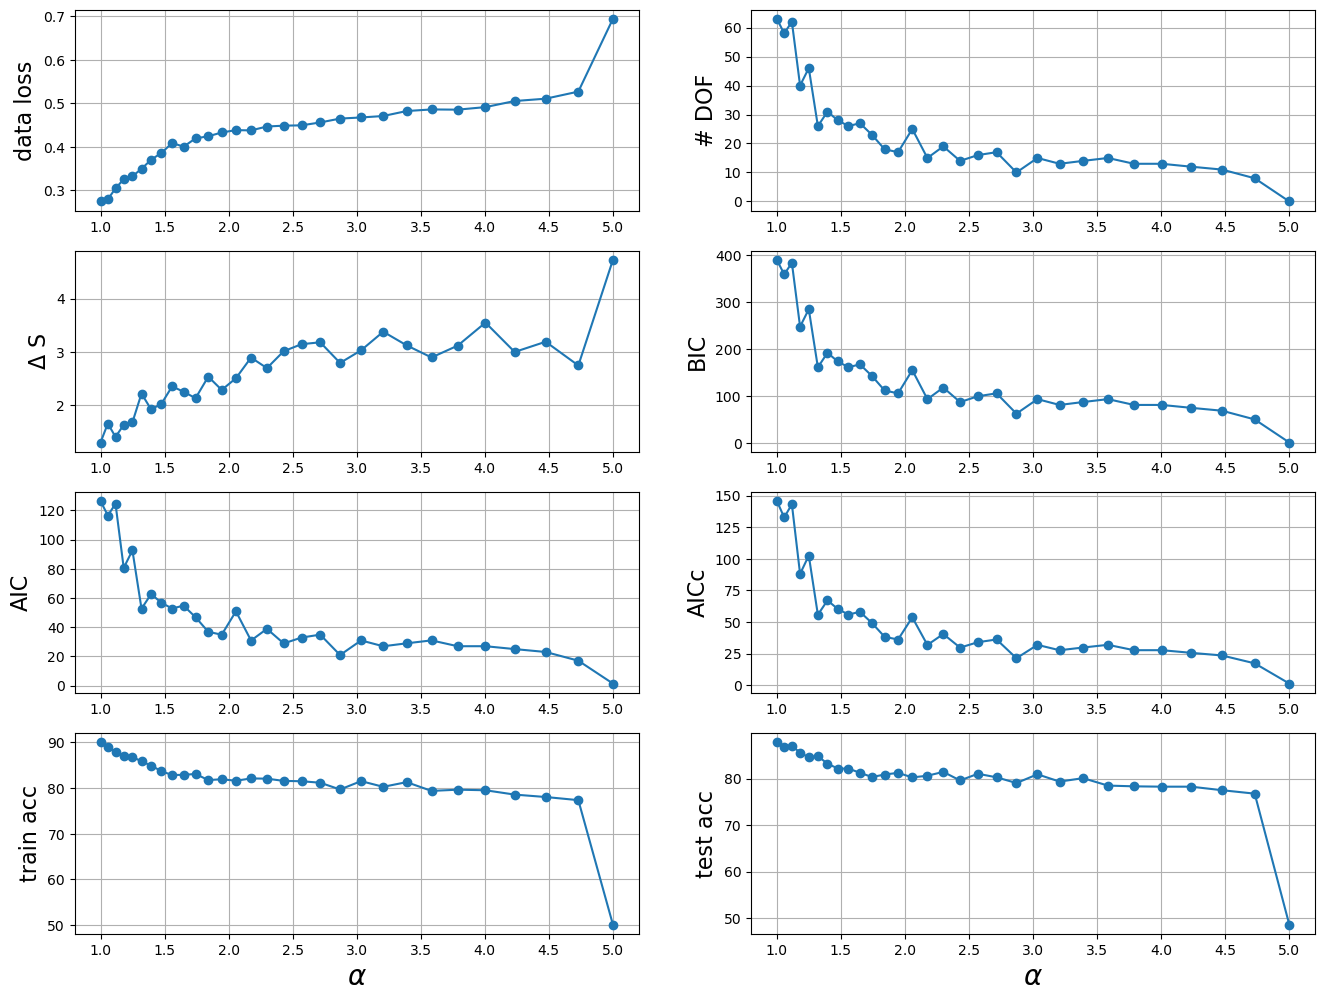

In [7]:
# plt.rc('figure', figsize=(16, 12))

rowcol = np.array([[1,2],
                   [3,4],
                   [5,6],
                   [7,8]])

ytxt = np.array([['data loss', '# DOF'], 
                 [r'$\Delta$ S', 'BIC'], 
                 ['AIC', 'AICc'], 
                 ['train acc', 'test acc']])

rows, cols = 4, 2

fig, axes = plt.subplots(rows,cols, figsize=(16, 12))
for row in range(rows):
    for col in range(cols):
        print(row, col, rowcol[row,col], ytxt[row,col])
        axes[row,col].plot(results[:,0], results[:,rowcol[row,col]], '-o')
        
        axes[row,col].grid(True)
        axes[row,col].set_ylabel(ytxt[row,col], fontsize=16)
        if row==3:
            axes[row,col].set_xlabel(r'$\alpha$', fontsize=20)
                                                 
# plt.savefig('bayes_loop.png')

### truncate if last few points are bad

In [8]:
ignore = 2

results = results[:-ignore]

scores = scores[:-ignore]

In [9]:
# model complexity measure: equation 2.16 of Abu-Mostafa

def Omega(N, dVC, delta):
    
    C = np.sqrt((8/N) * np.log(4*((2*N)**dVC + 1)/delta))
    
    return C

In [10]:
# dVC = np.linspace(1,50)
dVC = results[:,2]

# idxKeep = np.where(dVC>10)[0]
# idxKeep = np.where(dVC>(nFeatures-1))[0]
idxKeep = np.where(dVC>(nFeatures-5))[0]

dVC = dVC[idxKeep]

dataLoss = results[idxKeep,1]

N=100000

# complexity = Omega(N, dVC, 0.001)
complexity = Omega(N, dVC, 0.0001)

/tmp/ipykernel_22217/2898332194.py:5: RuntimeWarning: overflow encountered in power
  C = np.sqrt((8/N) * np.log(4*((2*N)**dVC + 1)/delta))
/tmp/ipykernel_22217/2898332194.py:5: RuntimeWarning: overflow encountered in divide
  C = np.sqrt((8/N) * np.log(4*((2*N)**dVC + 1)/delta))


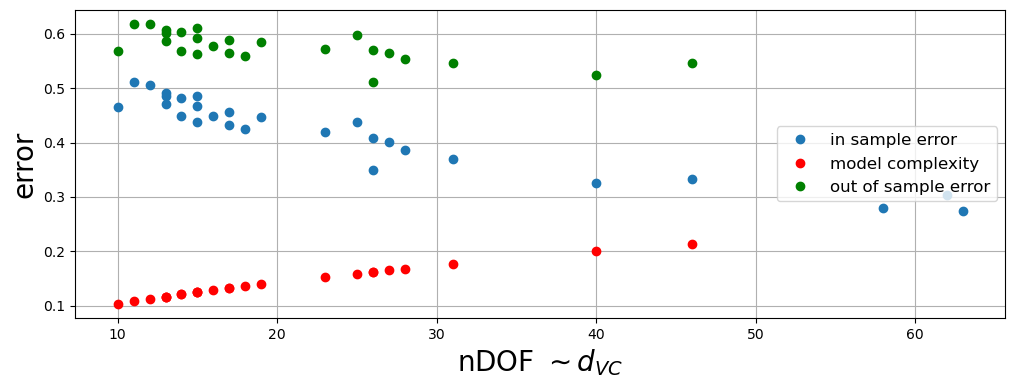

In [11]:
plt.rc('figure', figsize=(12, 4))

plt.plot(dVC, dataLoss, 'o', label='in sample error')

plt.plot(dVC,complexity, 'or', label='model complexity')
plt.plot(dVC,dataLoss+complexity, 'og', label='out of sample error')

plt.legend(fontsize=12, loc=5)

plt.xlabel('nDOF $\sim d_{VC}$', fontsize=20)
plt.ylabel('error', fontsize=20)

plt.grid(True)

# try this by first fitting some simple bilinear or decaying curve to nDOF vs loss

## fit nonlinear curves

In [12]:
from scipy.optimize import curve_fit

In [13]:
def nonlinear_ascend(x, a, b, c):
#     return a*np.log(b+x)+c
    y = a/(1 + np.exp(-b*(x-c))) # sigmoid function
    return y

def nonlinear_decay(x, a, b, c):
    return a*np.log(b+x)+c
    # y = a/(1 + np.exp(-b*(x-c))) # sigmoid function
    # y = 1/y
    return y

In [14]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
def piecewise_linear0(x, x0, y0, k1):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:y0])

In [15]:
x = results[:,0]
y2 = results[:,2] # nDOF
y3 = results[:,3] # dS

array([1.   , 1.057, 1.117, 1.181, 1.249, 1.32 , 1.395, 1.475, 1.559,
       1.648, 1.742, 1.841, 1.946, 2.057, 2.175, 2.299, 2.43 , 2.569,
       2.715, 2.87 , 3.034, 3.207, 3.39 , 3.584, 3.788, 4.005, 4.233,
       4.475])

In [37]:
popt_pwl2, pcov_pwl2 = curve_fit(piecewise_linear, x, y2, p0=[2, 20, -2, -1])
# popt_nl2, pcov_nl2 = curve_fit(nonlinear_decay, x, y2, p0=[3,-1,1])
popt_nl2, pcov_nl2 = curve_fit(nonlinear_decay, x, y2, p0=[3,0,1])

popt_nl3, pcov_nl3 = curve_fit(nonlinear_ascend, x, y3, p0=[3,-2,1])
popt_pwl3, pcov_pwl3 = curve_fit(piecewise_linear0, x, y3, p0=[3, 4, 1])

# print (popt_nl2)
print (popt_pwl2)
print (popt_pwl3)

[  1.4866421   22.18725545 -84.08311415  -4.28677059]
[2.55371768 3.12654709 1.04918304]


/tmp/ipykernel_22217/2066311247.py:7: RuntimeWarning: invalid value encountered in log
  return a*np.log(b+x)+c


In [38]:
popt_nlVC, pcov_nlVC = curve_fit(nonlinear_decay, dVC, dataLoss, p0=[2,-0.1,10])

fitLoss = nonlinear_decay(dVC, *popt_nlVC)

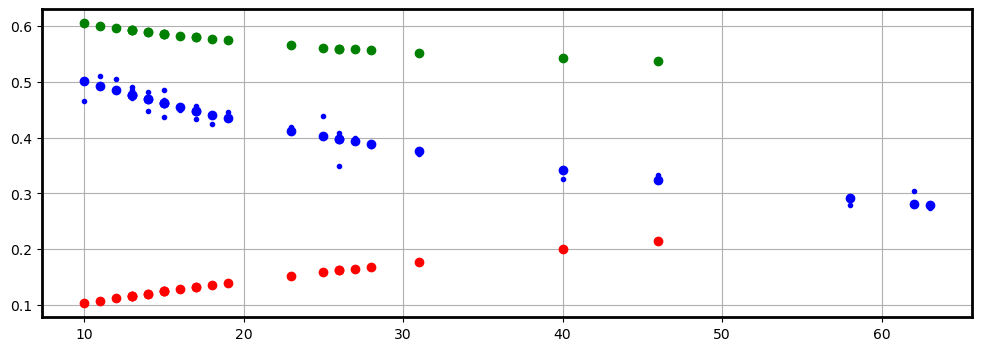

In [39]:
plt.rc('figure', figsize=(12, 4))

plt.plot(dVC, dataLoss, '.b')
plt.plot(dVC, fitLoss, 'ob')

plt.plot(dVC,complexity, 'or', label='model complexity')
plt.plot(dVC,fitLoss+complexity, 'og', label='out of sample error')

plt.grid(True)


### characteristic values of alpha from bilinear fits

In [40]:
alpha_nDOF_knee = np.round(popt_pwl2[0],2)
alpha_dS_max = np.round(popt_pwl3[0],2)

### find alpha where nDOF = total number of features

In [41]:
from scipy.optimize import fsolve
def f(x):
    y = piecewise_linear(x, *popt_pwl2)
    return y-nFeatures

starting_guess = np.ceil(popt_pwl2[0])

alpha_nDOF_nFeatures = np.round(fsolve(f, starting_guess),2)[0]

### best values of alpha

In [42]:
print ('alpha nDOF_knee: ', alpha_nDOF_knee)
print ('alpha dS_max: ', alpha_dS_max)
print ('alpha nDOF=nFeatures: ', alpha_nDOF_nFeatures)

alpha nDOF_knee:  1.49
alpha dS_max:  2.55
alpha nDOF=nFeatures:  4.33


## summary plots of fits used to determine alpha

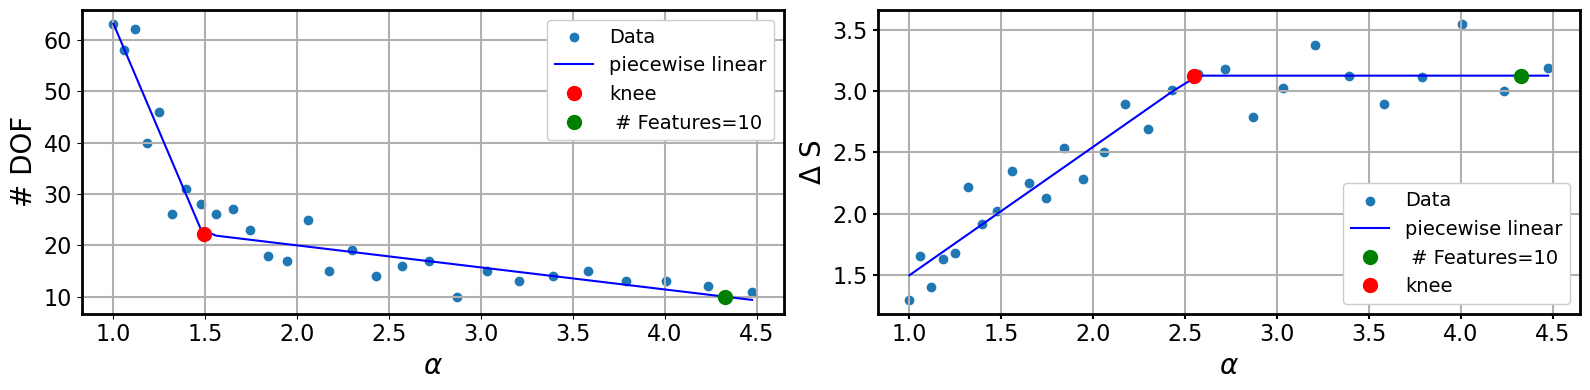

In [43]:
%matplotlib inline
# %matplotlib notebook

plt.rc('figure', figsize=(16, 4))
plt.rc('axes', linewidth=2)

plt.subplot(121)

plt.scatter(x, y2, label="Data")
plt.plot(x, piecewise_linear(x, *popt_pwl2), 'b-', label="piecewise linear")

plt.plot(alpha_nDOF_knee, piecewise_linear(alpha_nDOF_knee, *popt_pwl2), 'or',
         markersize=10, label='knee')
plt.plot(alpha_nDOF_nFeatures, piecewise_linear(alpha_nDOF_nFeatures, *popt_pwl2), 'og', 
         markersize=10, label=' # Features='+str(nFeatures))
# plt.plot(alpha_dS_max, piecewise_linear(alpha_dS_max, *popt_pwl2), '^r',
#          markersize=10)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel('# DOF', fontsize=20)

plt.grid(True, linewidth=1.5)

plt.legend(fontsize=14, framealpha=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#######################################################3
plt.subplot(122)

plt.scatter(x, y3, label="Data")
plt.plot(x, piecewise_linear0(x, *popt_pwl3), 'b-', label="piecewise linear")

# plt.plot(alpha_nDOF_knee, piecewise_linear0(alpha_nDOF_knee, *popt_pwl3), 'or',
#          markersize=10)
plt.plot(alpha_nDOF_nFeatures, piecewise_linear0(alpha_nDOF_nFeatures, *popt_pwl3), 'og',
         markersize=10, label=' # Features='+str(nFeatures))
plt.plot(alpha_dS_max, piecewise_linear0(alpha_dS_max, *popt_pwl3), 'or',
         markersize=10, label='knee')
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$\Delta$ S', fontsize=20)

plt.grid(True, linewidth=1.5)

plt.legend(fontsize=14, framealpha=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)

plt.tight_layout()

# plt.savefig('BNN_alpha_loop_fits_300dpi.png', dpi=300)
# plt.savefig('BNN_alpha_loop_fits_600dpi.png', dpi=600)

## classification report plots

1
2
3
4


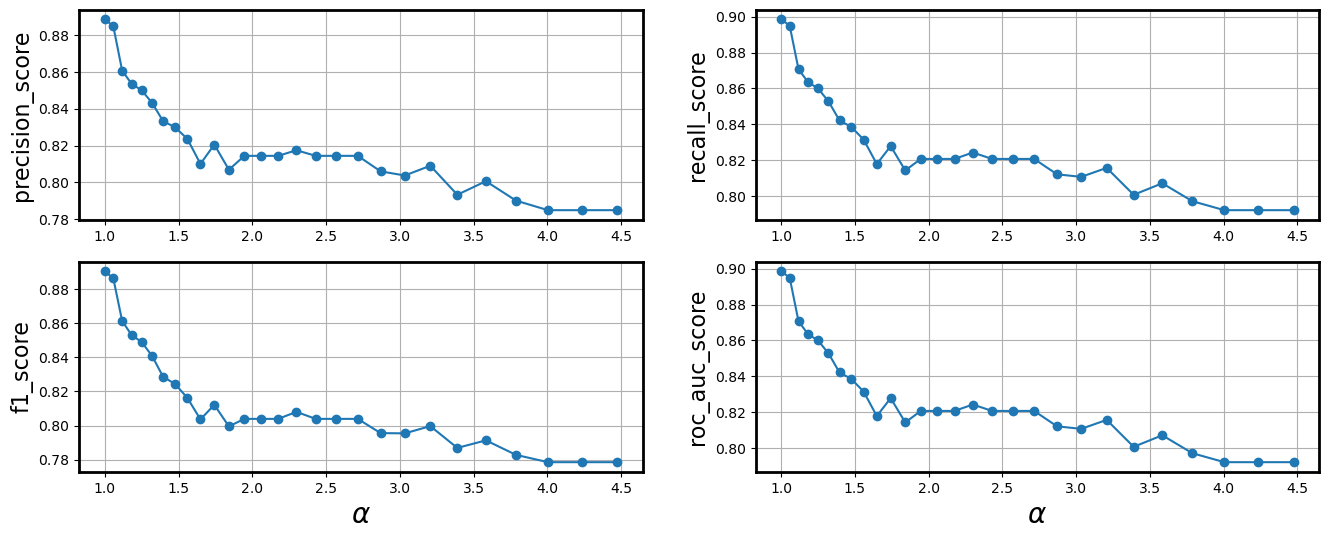

In [44]:
%matplotlib inline

plt.rc('figure', figsize=(16, 6))

rowcol = np.array([[1,2],
                   [3,4]])

ytxt = np.array([['precision_score', 'recall_score'], 
                 ['f1_score', 'roc_auc_score']])

rows, cols = 2, 2

fig, axes = plt.subplots(rows,cols)
for row in range(rows):
    for col in range(cols):
        print (rowcol[row,col])
        axes[row,col].plot(scores[:,0], scores[:,rowcol[row,col]], '-o')
        
        axes[row,col].grid(True)
        axes[row,col].set_ylabel(ytxt[row,col], fontsize=16)
        if row==1:
            axes[row,col].set_xlabel(r'$\alpha$', fontsize=20)